# Stock Price Prediction using LSTM and XGBoost

## Introduction

This notebook demonstrates stock price prediction using two machine learning models: LSTM (Deep Learning) and XGBoost (Traditional ML). The data is fetched from Alpaca using their API. We will compare the performance of both models based on RMSE, MAE, and R² metrics.

## Libraries and Environment Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

ALPACA_API_KEY_ID = os.getenv("APCA_API_KEY_ID")
ALPACA_API_SECRET_KEY = os.getenv("APCA_API_SECRET_KEY")

## Data Collection

Fetching the daily stock price for AAPL from January 1, 2018.

In [2]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

# Initialize client
data_client = StockHistoricalDataClient(ALPACA_API_KEY_ID, ALPACA_API_SECRET_KEY)

# Fetch daily data for a ticker
daily_request = StockBarsRequest(
    symbol_or_symbols=["AAPL"], 
    timeframe=TimeFrame.Day, 
    start=pd.Timestamp("2018-01-01", tz='America/New_York')
)
    
daily_bars = data_client.get_stock_bars(daily_request).df

## Feature Engineering

We compute a variety of technical indicators including MACD, Bollinger Bands, ATR, OBV, VWAP, and more using the TA-Lib library.

In [3]:
import ta

# Create a copy of our data for feature engineering
df = daily_bars.copy()

# Calculate technical indicators
df["macd"] = ta.trend.MACD(df["close"]).macd()
df["macd_signal"] = ta.trend.MACD(df["close"]).macd_signal()
df["macd_diff"] = ta.trend.MACD(df["close"]).macd_diff()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(df["close"])
df["bollinger_h"] = bollinger.bollinger_hband()
df["bollinger_l"] = bollinger.bollinger_lband()
df["bollinger_m"] = bollinger.bollinger_mavg()
df["bb_width"] = (df["bollinger_h"] - df["bollinger_l"]) / df["bollinger_m"]

# Volatility indicators
df["atr"] = ta.volatility.AverageTrueRange(df["high"], df["low"], df["close"]).average_true_range()
df["daily_return"] = df["close"].pct_change()
df["volatility_14"] = df["daily_return"].rolling(window=14).std()

# Volume indicators
df["obv"] = ta.volume.OnBalanceVolumeIndicator(df["close"], df["volume"]).on_balance_volume()
df["volume_sma"] = df["volume"].rolling(window=20).mean()
df["volume_ratio"] = df["volume"] / df["volume_sma"]

# Trend indicators
df["adx"] = ta.trend.ADXIndicator(df["high"], df["low"], df["close"]).adx()
df["sma_20"] = ta.trend.SMAIndicator(df["close"], window=20).sma_indicator()
df["sma_50"] = ta.trend.SMAIndicator(df["close"], window=50).sma_indicator()
df["ema_20"] = ta.trend.EMAIndicator(df["close"], window=20).ema_indicator()

# VWAP (Volume Weighted Average Price)
df["vwap"] = (df["close"] * df["volume"]).cumsum() / df["volume"].cumsum()

# RSI
df["rsi"] = ta.momentum.RSIIndicator(df["close"]).rsi()

# Price-based features
df["price_sma_ratio"] = df["close"] / df["sma_20"]
df["high_low_ratio"] = df["high"] / df["low"]

df = df.dropna()

# Select features for modeling - exclude OHLCV
columns_to_drop = []
for col in ["open", "high", "low", "close", "volume", "symbol", "trade_count"]:
    if col in df.columns:
        columns_to_drop.append(col)
        
features = df.drop(columns=columns_to_drop)

## Data Preparation

Normalize the features and create input sequences of 60 days for LSTM training, and split the data into training and testing sets.

In [4]:
# Define the timesteps and number of features
timesteps = 60
n_features = features.shape[1]

# Normalize/scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df[["close"]])

# Create the input data (X) and output data (y) for training
X = []
y = []

for i in range(timesteps, len(df)):
    X.append(scaled_features[i-timesteps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Model Training

### LSTM Model

#### Model Training

In [5]:
from keras.src.models import Sequential
from keras.src.layers import Input, LSTM, Dense, Dropout
from keras.src.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lstm_model = Sequential([
    Input(shape=(timesteps, n_features)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
lstm_preds = lstm_model.predict(X_test)
lstm_preds = scaler_target.inverse_transform(lstm_preds)
y_test_actual = scaler_target.inverse_transform(y_test)

Epoch 1/500


2025-05-14 20:12:57.175276: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-14 20:12:57.175294: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 20:12:57.175297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1747267977.175307  447818 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747267977.175323  447818 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-14 20:12:57.589776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1747267977.592292  447818 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0455 - val_loss: 0.0054
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0092 - val_loss: 3.6185e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0058 - val_loss: 4.5765e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0040 - val_loss: 9.2590e-04
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 9.1911e-04
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026 - val_loss: 3.4254e-04
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 2.2427e-04
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0050 - val_loss: 7.6808e-04
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - val_loss: 2.2623e-04
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 6.3292e-04
Epoch 12/500
20/20 ━━━━━━━━━

#### Model Evaluation

In [6]:
# Evaluate LSTM model
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)
lstm_r2 = r2_score(y_test_actual, lstm_preds)

print(f"LSTM RMSE: ${lstm_rmse:.2f}")
print(f"LSTM MAE: ${lstm_mae:.2f}")
print(f"LSTM R²: {lstm_r2:.4f}")

LSTM RMSE: $9.52
LSTM MAE: $7.16
LSTM R²: 0.8469


### XGBoost

#### Model Training

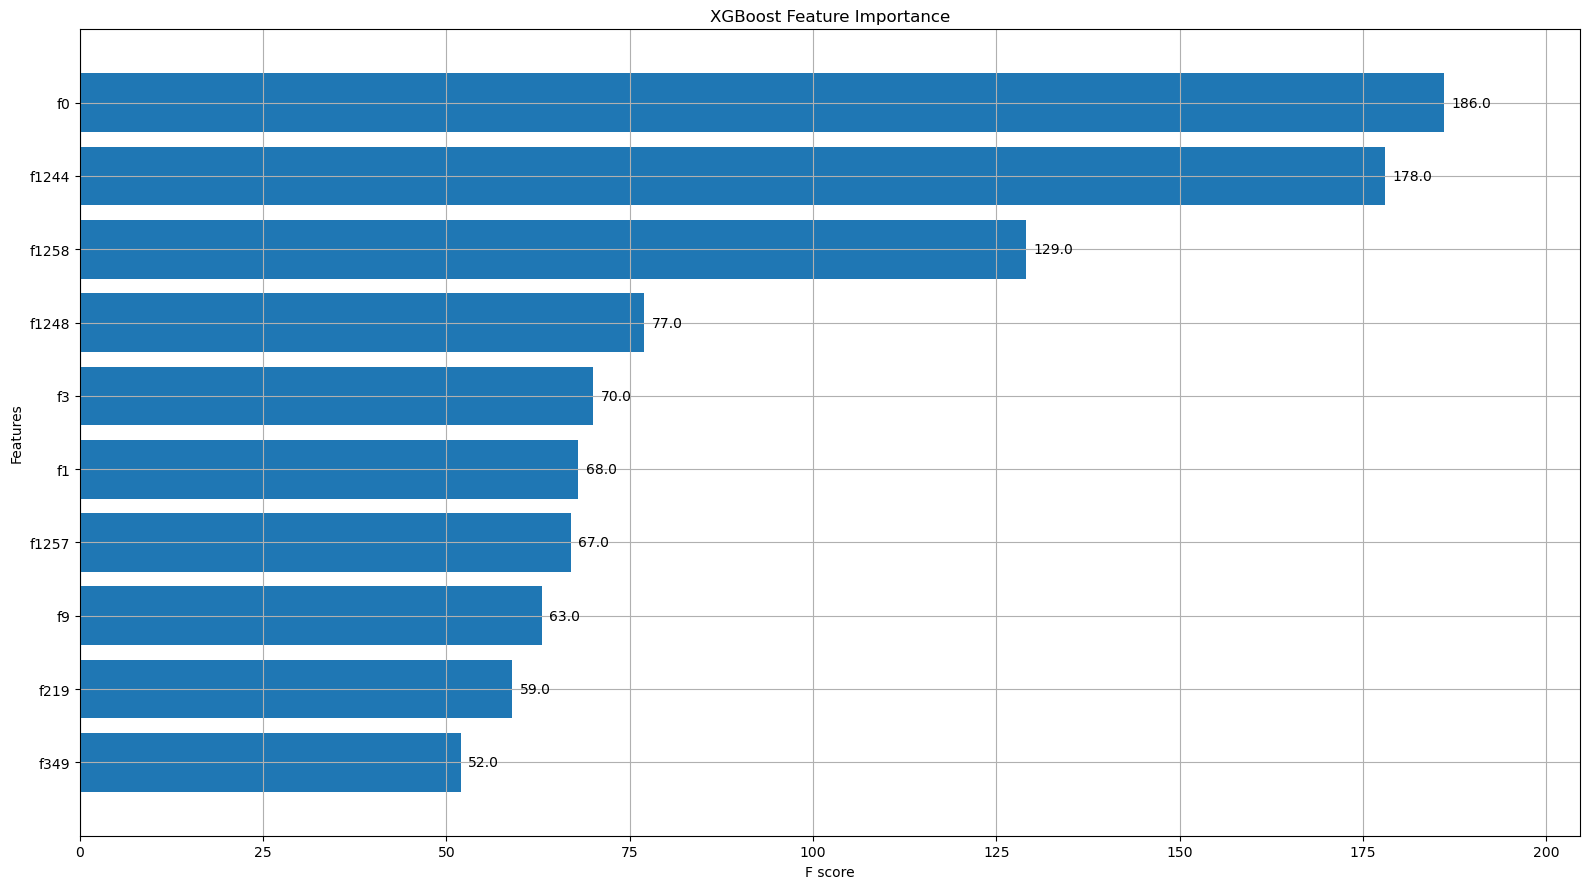

In [7]:
import xgboost as xgb

# Reshape X_train and X_test from 3D to 2D for XGBoost: (samples, timesteps * n_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train XGBoost model for regression
xgb_model = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=4,
    reg_lambda=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_reshaped, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test_reshaped)
xgb_preds = xgb_preds.reshape(-1, 1)
xgb_preds = scaler_target.inverse_transform(xgb_preds)

# Plot feature importance for XGBoost
# Create figure and axis with desired size
fig, ax = plt.subplots(figsize=(16, 9))

# Plot feature importance on the custom axis
xgb.plot_importance(xgb_model, max_num_features=10, height=0.8, ax=ax)

# Title and layout
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('images/xgboost_feature_importance.png')
plt.show()

#### Model Evaluation

In [8]:
# Evaluate XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test_actual, xgb_preds))
xgb_mae = mean_absolute_error(y_test_actual, xgb_preds)
xgb_r2 = r2_score(y_test_actual, xgb_preds)

print(f"XGBoost RMSE: ${xgb_rmse:.2f}")
print(f"XGBoost MAE: ${xgb_mae:.2f}")
print(f"XGBoost R²: {xgb_r2:.4f}")

XGBoost RMSE: $12.94
XGBoost MAE: $10.18
XGBoost R²: 0.7173


## Comparison

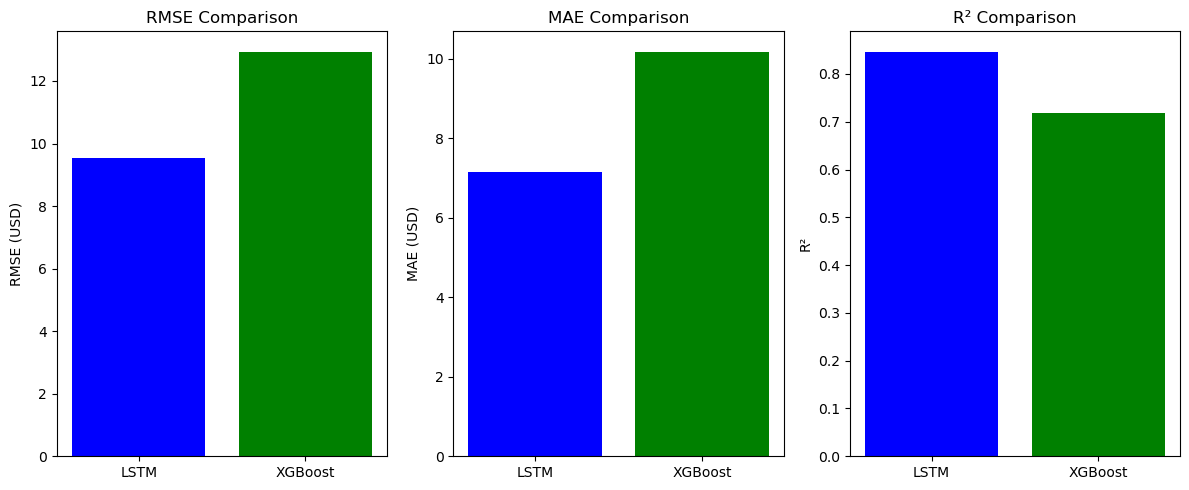

In [9]:
models = ['LSTM', 'XGBoost']
rmse_values = [lstm_rmse, xgb_rmse]
mae_values = [lstm_mae, xgb_mae]
r2_values = [lstm_r2, xgb_r2]

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (USD)')

plt.subplot(1, 3, 2)
plt.bar(models, mae_values, color=['blue', 'green'])
plt.title('MAE Comparison')
plt.ylabel('MAE (USD)')

plt.subplot(1, 3, 3)
plt.bar(models, r2_values, color=['blue', 'green'])
plt.title('R² Comparison')
plt.ylabel('R²')

plt.tight_layout()
plt.savefig('images/model_comparison.png')
plt.show()

## Visualization

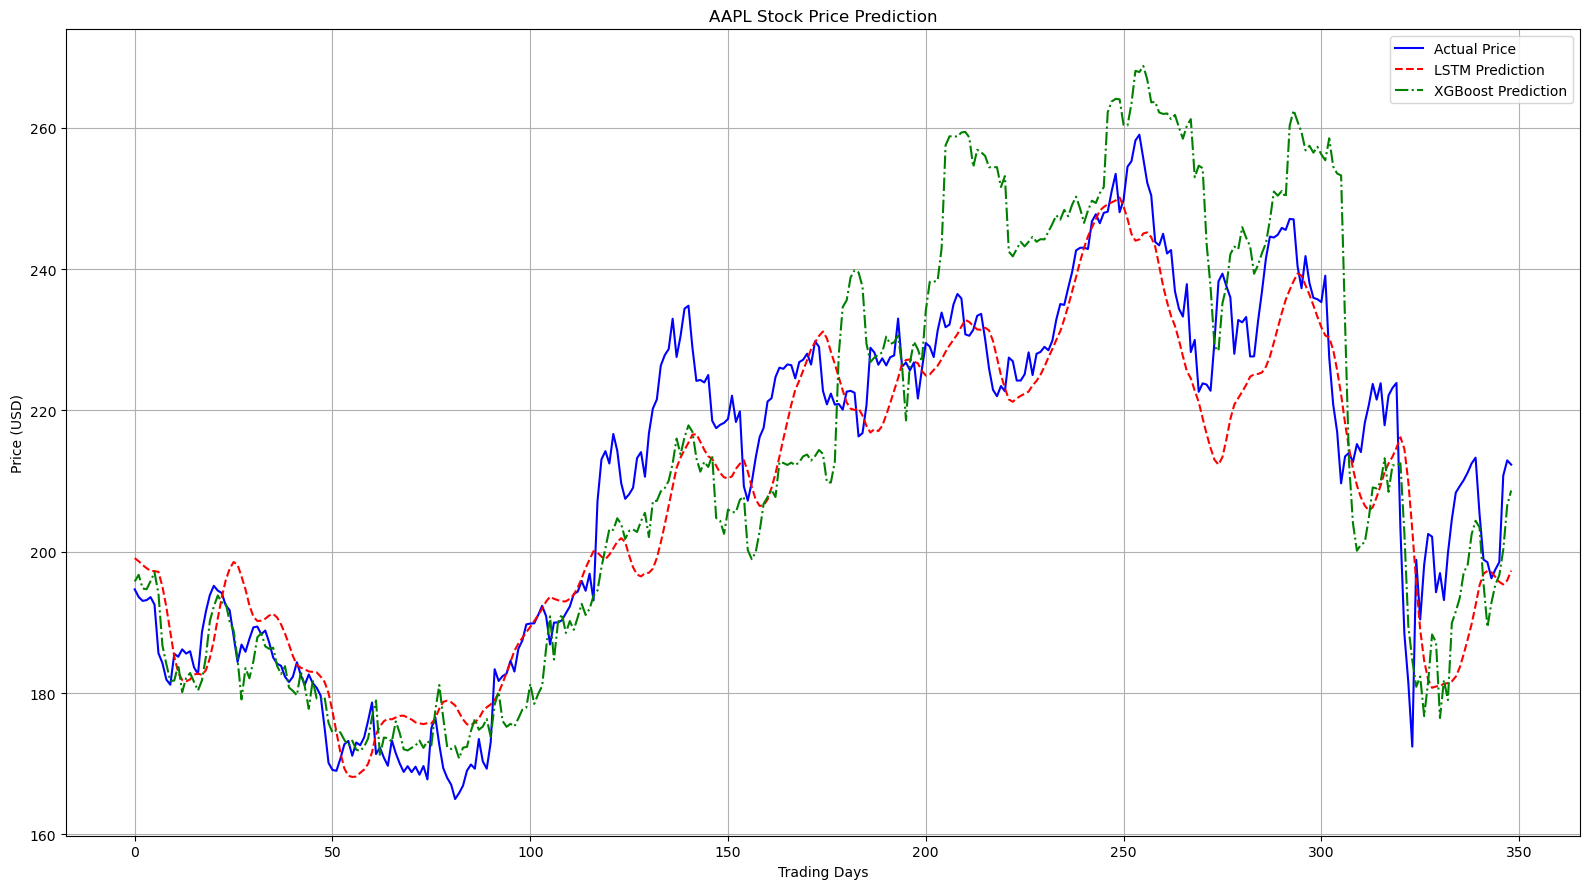

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(lstm_preds, label='LSTM Prediction', color='red', linestyle='--')
plt.plot(xgb_preds, label='XGBoost Prediction', color='green', linestyle='-.')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Trading Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('images/stock_predictions_comparison.png')
plt.show()

## Prediction

This will predict next day's price based on the trained models.

In [11]:
def predict_next_day(model, last_sequence, is_lstm=True):
    """
    Predict the next day's closing price
    
    Parameters:
    model: trained model (LSTM or XGBoost)
    last_sequence: the last timesteps sequence of data
    is_lstm: boolean flag for model type
    
    Returns:
    predicted price for the next day
    """
    # Make sure the sequence has the right shape
    sequence = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]) if is_lstm else last_sequence.reshape(1, -1)
    
    # Predict
    prediction = model.predict(sequence)
    
    # Reshape prediction to 2D if it's 1D (for XGBoost)
    if len(prediction.shape) == 1:
        prediction = prediction.reshape(-1, 1)
    
    # Inverse transform to get actual price
    return scaler_target.inverse_transform(prediction)[0][0]

## Demo

Using `predict_next_day()` to predict the price for using both models.

In [12]:
last_sequence = X_test[-1]
next_day_lstm = predict_next_day(lstm_model, last_sequence, is_lstm=True)
next_day_xgb = predict_next_day(xgb_model, last_sequence, is_lstm=False)

print(f"LSTM Next Day Prediction: ${next_day_lstm:.2f}")
print(f"XGBoost Next Day Prediction: ${next_day_xgb:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM Next Day Prediction: $197.33
XGBoost Next Day Prediction: $208.67
